맷플롭립으로 그래프를 그려본 결과 alcohol 특성 quality와 비례하는 것을 알게되었습니다. alcohol의 제곱을 갖는
sqalco 라는 특성을 추가해주었습니다.
주어진 csv파일을 5등분해서 3개분을 training 으로 1개분을 validate로 1개분을 test로 활용할것입니다.
5등분중 어떤 부분이 전체 데이터를 잘 대표하는지 알기 위해서 순열을 사용해서 총 20번 동안 반복문을 돌아
가장 퍼포먼스가 좋은 경우를 골랐습니다.

In [1]:
import pandas as pd
from autograd import numpy as np
from autograd import grad
from sklearn.preprocessing import StandardScaler
def logistic(x):
    out = 1. / (1. + np.exp(-x))
    return out
def logistic_model(x,params):
    out = logistic(np.dot(x,params[0])+params[1])
    return out
def model_loss(x,true_labels,params,_lambda=1.0):
    pred = logistic_model(x,params)

    loss =  - (np.dot(true_labels, np.log(pred+1e-15)) + np.dot(1.-true_labels, np.log(1.-pred+1e-15))) \
        + _lambda * np.sum(params[0]**2)
    return loss
def classify(x,params):
    probabilities = logistic_model(x,params)
    labels = (probabilities >= 0.5).astype(float)
    return labels
def performance(predictions, answers, beta = 1.0):
    true_idx = (answers == 1)
    false_idx = (answers == 0)

    n_tp = np.count_nonzero(predictions[true_idx] == 1)

    n_fp = np.count_nonzero(predictions[false_idx] == 1)

    n_tn = np.count_nonzero(predictions[false_idx] == 0)

    n_fn = np.count_nonzero(predictions[true_idx] == 0)

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)

    score = ((1.0 + beta**2) * precision * recall / (beta ** 2 * precision + recall))

    accuracy = (n_tp + n_tn) / (n_tp + n_fp + n_tn + n_fn)

    return precision,recall,score,accuracy

In [2]:
from itertools import permutations as pm

pm_helper = [0,1,2,3,4]

pm_list = pm(pm_helper,2)

sqalco_datas = pd.read_csv("winequality-red.csv")
sqalco_datas=sqalco_datas.append(sqalco_datas.loc[0],ignore_index = True)

#print(sqalco_datas.shape[0])
#sqalco_datas = sqalco_datas.sample(frac=1).reset_index(drop=True)



sqalco_datas["sqalco"] = [0.] * sqalco_datas.shape[0]

for i in range(sqalco_datas.shape[0]):
    sqalco_datas["sqalco"][i] = sqalco_datas["alcohol"][i] ** 2

y_col = "quality"
x_cols = sqalco_datas.columns.drop(["quality"])

for i in range(len(sqalco_datas[y_col])):
    if sqalco_datas[y_col][i] < 6:
        sqalco_datas[y_col][i] = 0.0
    else:
        sqalco_datas[y_col][i] = 1.0

sqalco_datas[x_cols] = StandardScaler().fit_transform(sqalco_datas[x_cols])




num_of_datas = sqalco_datas.shape[0]
num_of_features = len(x_cols)
#print(num_of_datas,num_of_features)

best_scores = 0.0
best_w = None
best_b = None
best_fsc = 0.0
best_acc = 0.0
iters0 = None
iters1 = None

datas_division = np.split(sqalco_datas[x_cols],5,0)
labels_division = np.split(sqalco_datas[y_col],5,0)

assert datas_division[0].shape[0] == labels_division[0].shape[0]
assert datas_division[1].shape[0] == labels_division[1].shape[0]
assert datas_division[2].shape[0] == labels_division[2].shape[0]
assert datas_division[3].shape[0] == labels_division[3].shape[0]
assert datas_division[4].shape[0] == labels_division[4].shape[0]
wtt = 0
for iters in pm_list:
    wtt += 1
    pm_helper = [0,1,2,3,4]

    datas_val=datas_division[iters[0]].values
    datas_test = datas_division[iters[1]].values

    labels_val = labels_division[iters[0]].values
    labels_test = labels_division[iters[1]].values

    pm_helper.remove(iters[0])
    pm_helper.remove(iters[1])
    
    datas_train=np.vstack((datas_division[pm_helper[0]].values,datas_division[pm_helper[1]].values,datas_division[pm_helper[2]].values))


    labels_train=np.hstack((labels_division[pm_helper[0]].values,labels_division[pm_helper[1]].values,labels_division[pm_helper[2]].values))

    

    
    #print(labels_train.shape)
    #print(datas_train.shape)
    assert labels_train.shape[0] == datas_train.shape[0]
    assert labels_val.shape[0] == datas_val.shape[0]
    assert labels_test.shape[0] == datas_test.shape[0]

    gradients = grad(model_loss,argnum = 2)

    w = np.zeros(datas_train.shape[1],dtype=float)

    b=0.

    lr = 1e-5

    change = np.Inf

    i = 0

    old_val_loss = 1e-15

    while change >= 1e-15 and i<10000:#
        grads = gradients(datas_train, labels_train,(w,b))
        w-=(grads[0] * lr)
        b-=(grads[1] * lr)

        val_loss = model_loss(datas_val,labels_val,(w,b))

        pred_labels_val = classify(datas_val, (w,b))
        score = performance(pred_labels_val, labels_val)

        change = np.abs((val_loss - old_val_loss)/old_val_loss)

        i += 1
        old_val_loss = val_loss

        if i% 5000 == 0:
            print("{}...".format(i),end="")
        if wtt%10 and i%500 == 0:
            print("와우!!!")
    if ( score[3] + score[2] ) > best_scores:
        best_b = b
        best_w = w
        best_fsc = score[2]
        best_acc = score[3]
        best_scores = score[3] + score[2]
        iters0 = iters[0]
        iters1 = iters[1]
#print("")
#print("")
#print("Upon optimization stopped:")
#print("    Iterations:", i)
#print("    Validation loss:", val_loss)
#print("    Validation precision:", score[0])
#print("    Validation recall:", score[1])
print("    Validation F-score:", score[2])
print("    Validation Accuracy:", score[3])
print("    Change in validation loss:", change)

와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
10000...와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
와우!!!
5

In [3]:
print(best_fsc,best_acc,best_b,best_w)

0.8697674418604651 0.8055555555555556 0.2240490123547769 [ 0.22510538 -0.68556668 -0.2680487  -0.04079619 -0.14484279  0.3138903
 -0.71775561  0.13982565  0.13648678  0.40877563  0.43929911  0.44778318]


In [4]:
tdatas = pd.read_csv("winequality-red_test.csv")
tdatas["sqalco"] = [0.] * tdatas.shape[0]

for i in range(tdatas.shape[0]):
    tdatas["sqalco"][i] = tdatas["alcohol"][i] ** 2

tdatas = StandardScaler().fit_transform(tdatas)
dec = classify(tdatas,(best_w,best_b))

outdatas=pd.read_csv("sample_sub.csv")
for i in range(len(outdatas["quality"])):
    outdatas["quality"][i] = int(dec[i])
outdatas.to_csv("./result2.csv",index=False)

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


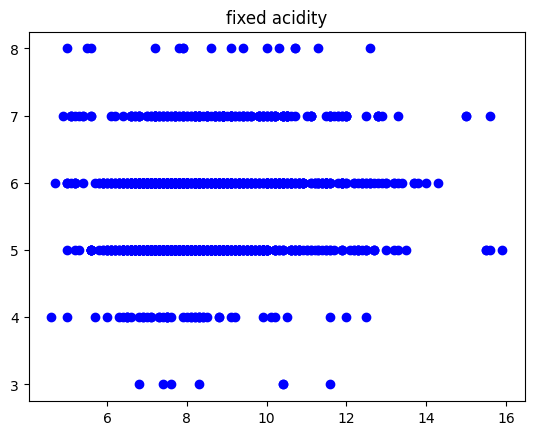

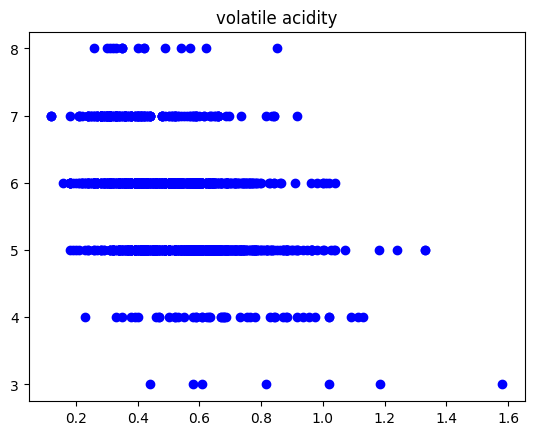

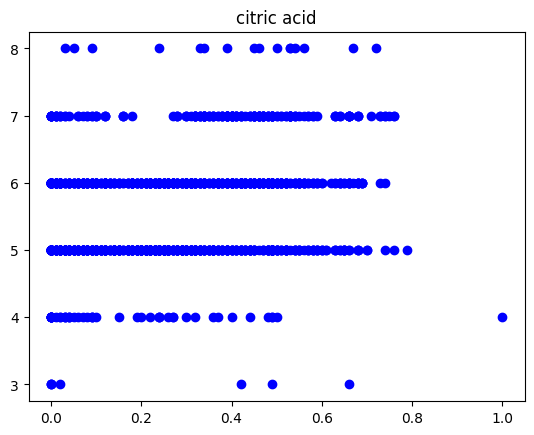

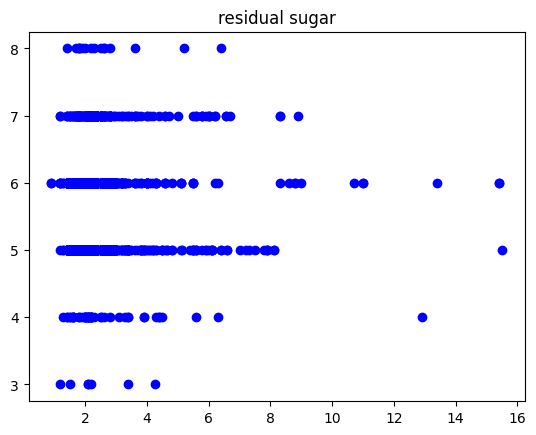

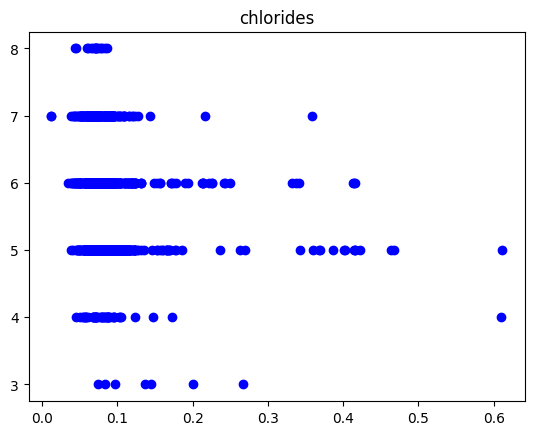

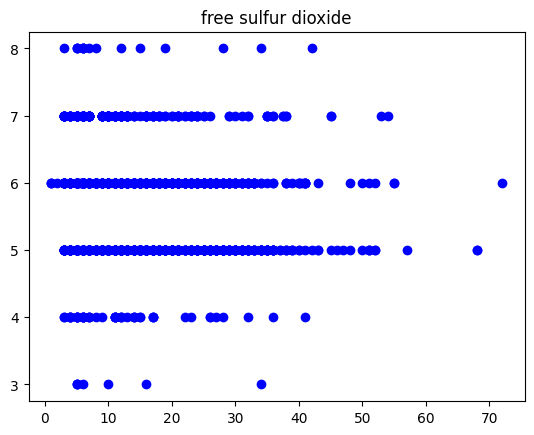

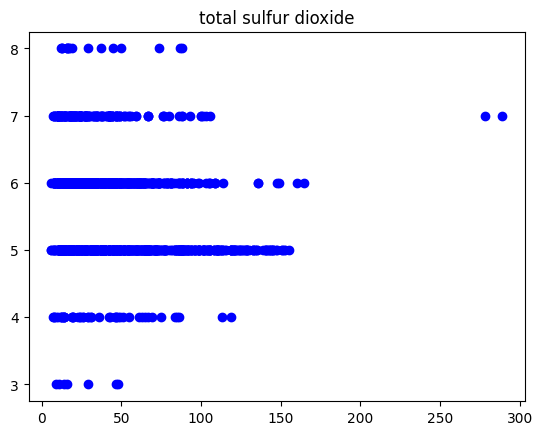

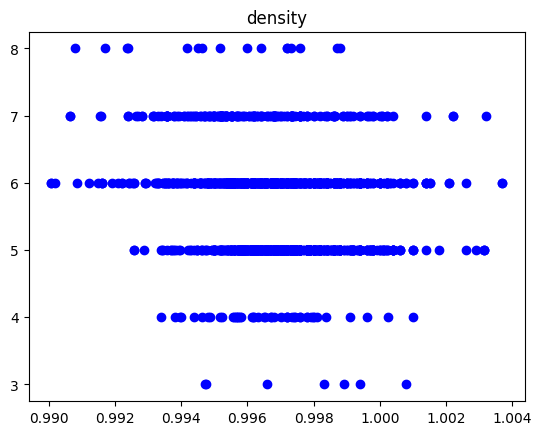

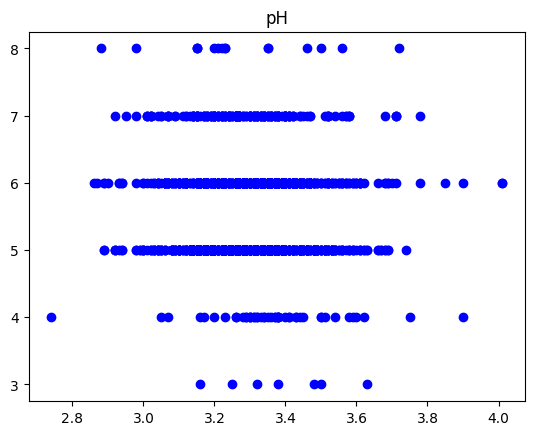

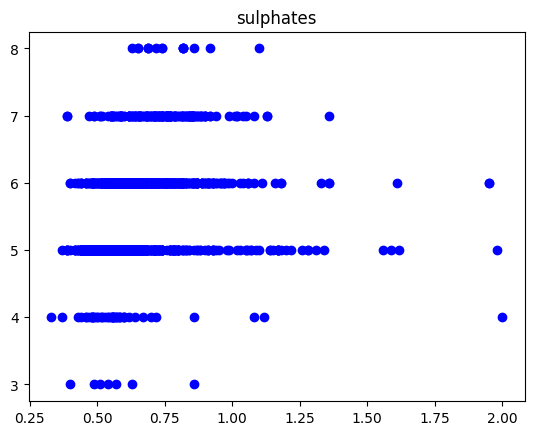

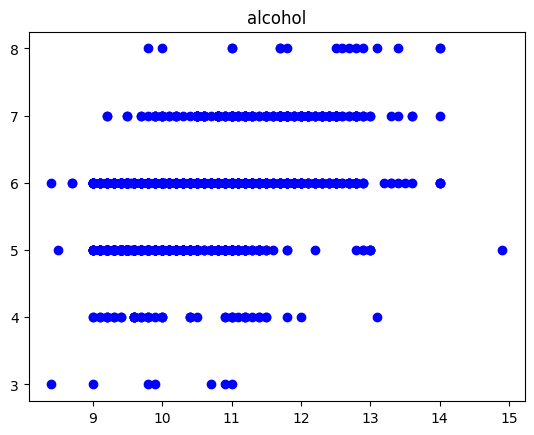

In [7]:
import matplotlib.pyplot as plt
import time
#plt.figure(figsize=(5,5))
pltdatas = pd.read_csv("winequality-red.csv")
for i in range(11):
    plt.plot(pltdatas[x_cols[i]],pltdatas[y_col],"bo")
    plt.title(x_cols[i])
    plt.show()